In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.fft import fft, ifft, fftfreq
import scipy
import random

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_impulse(a=0.0, b=20.0, A=1, period=7.5, fc = 10_000, noise=None):
    t = np.linspace(a, b, fc)
    signal = np.array([(A if ti % (period * 2) >= period else 0) for ti in t])
    if noise:
        max_noize, min_noize = 1, -1
        for i in range(len(signal)):
            signal[i] += ((np.random.rand() * (max_noize - min_noize) + min_noize) * noise)
    return t, signal

In [5]:
def get_cos_singal(f=[50,150,450], fs=10000, A=2.0, a=-1, b=1, noise=None):
    t = np.linspace(a, b, fs)
    omegas = [2 * np.pi * f_curr for f_curr in f]
    x_cos = np.sum([A * np.cos(omega * t) for omega in omegas], axis=0)
    if noise:
        max_noize, min_noize = 1, -1
        for i in range(len(x_cos)):
            x_cos[i] += ((np.random.rand() * (max_noize - min_noize) + min_noize) * noise)
    return t, x_cos

# 1.

In [6]:
def moving_average_filter(signal, k):
    filtered_signal = np.convolve(signal, np.ones(2 * k + 1) / (2 * k + 1), mode='same')
    return filtered_signal

def compute_spectrum(signal, fs):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / fs)[:N // 2]
    return xf, np.abs(yf[:N // 2])

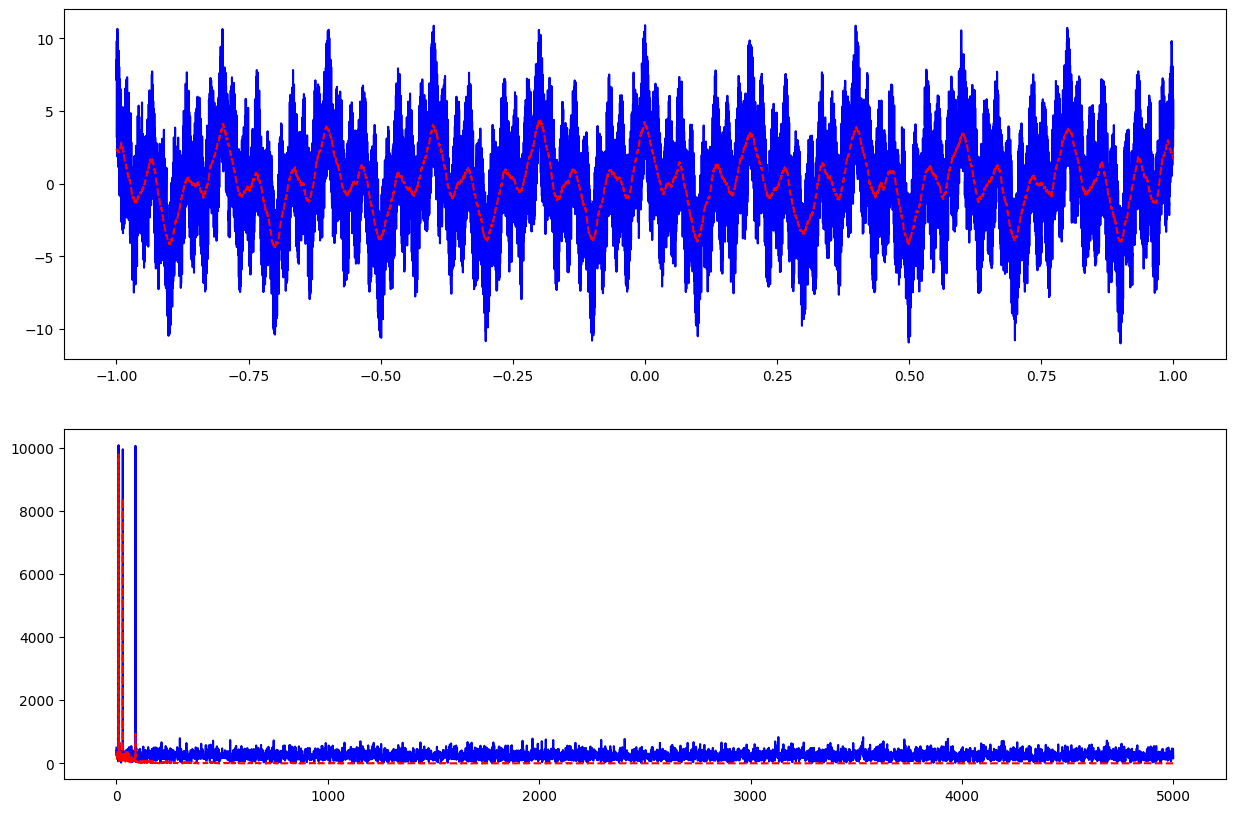

In [7]:
fs = 10_000
t, signal = get_cos_singal(f=[5, 15, 45],fs=fs, a=-1.0, b=1.0, noise=5)
signal_filtred = moving_average_filter(signal, 50)
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='signal', color='blue')
plt.plot(t, signal_filtred, label='signal_filtred', color='red', linestyle='--')

signal_fft, y_fft = compute_spectrum(signal, fs)
signal_filtred_fft, y_filtred_fft = compute_spectrum(signal_filtred, fs)
plt.subplot(2, 1, 2)
plt.plot(signal_fft, y_fft, label='signal_fft', color='blue')
plt.plot(signal_filtred_fft, y_filtred_fft, label='signal_filtred_fft', color='red', linestyle='--')

# 2.

In [8]:
def gaussian_filter(signal, w):
    kernel_size = int(6 * w)
    kernel_half = kernel_size // 2
    x = np.arange(-kernel_half, kernel_half + 1)
    gaussian_kernel = np.exp(-4 * np.log(2) * x**2 / w**2)
    gaussian_kernel /= np.sum(gaussian_kernel)
    filtered_signal = np.convolve(signal, gaussian_kernel, mode='same')
    return filtered_signal

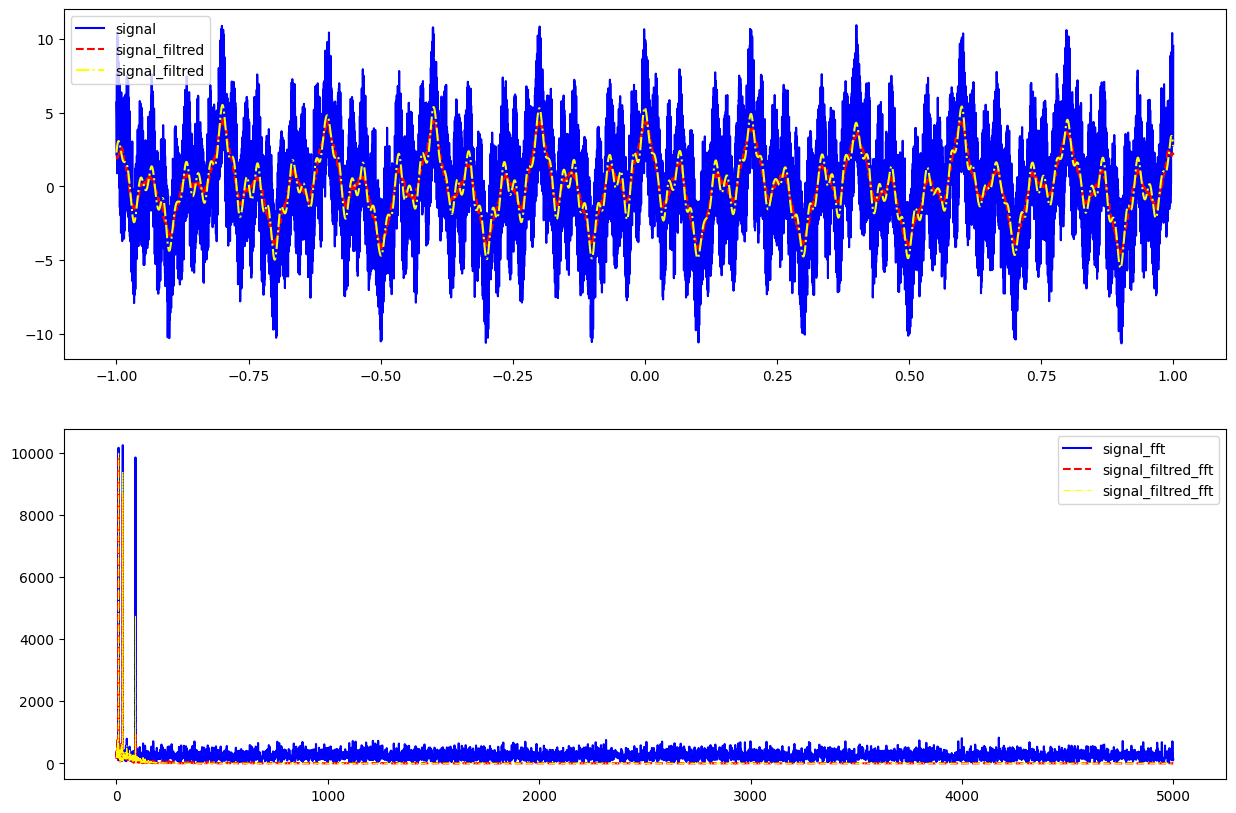

In [9]:
fs = 10_000
t, signal = get_cos_singal(f=[5, 15, 45],fs=fs, a=-1.0, b=1.0, noise=5)
signal_filtred_1 = moving_average_filter(signal, 50)
signal_filtred_2 = gaussian_filter(signal, 50)
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='signal', color='blue')
plt.plot(t, signal_filtred_1, label='signal_filtred', color='red', linestyle='--')
plt.plot(t, signal_filtred_2, label='signal_filtred', color='yellow', linestyle='-.')
plt.legend()

signal_fft, y_fft = compute_spectrum(signal, fs)
signal_filtred_1_fft, y_filtred_1_fft = compute_spectrum(signal_filtred_1, fs)
signal_filtred_2_fft, y_filtred_2_fft = compute_spectrum(signal_filtred_2, fs)

plt.subplot(2, 1, 2)
plt.plot(signal_fft, y_fft, label='signal_fft', color='blue')
plt.plot(signal_filtred_1_fft, y_filtred_1_fft, label='signal_filtred_fft', color='red', linestyle='--')
plt.plot(signal_filtred_2_fft, y_filtred_2_fft, label='signal_filtred_fft', color='yellow', linestyle='-.', linewidth=0.8)
plt.legend()

# 3.

In [10]:
def generate_spike_signal(fs=10_000, a=0.0, b=1.0, spike_prob=0.05, A=1.0):
    t = np.linspace(a, b, fs)
    signal = np.zeros(fs)
    spikes = np.random.rand(fs) < spike_prob
    spikes = [A if i else 0.0 for i in spikes]
    return t, spikes

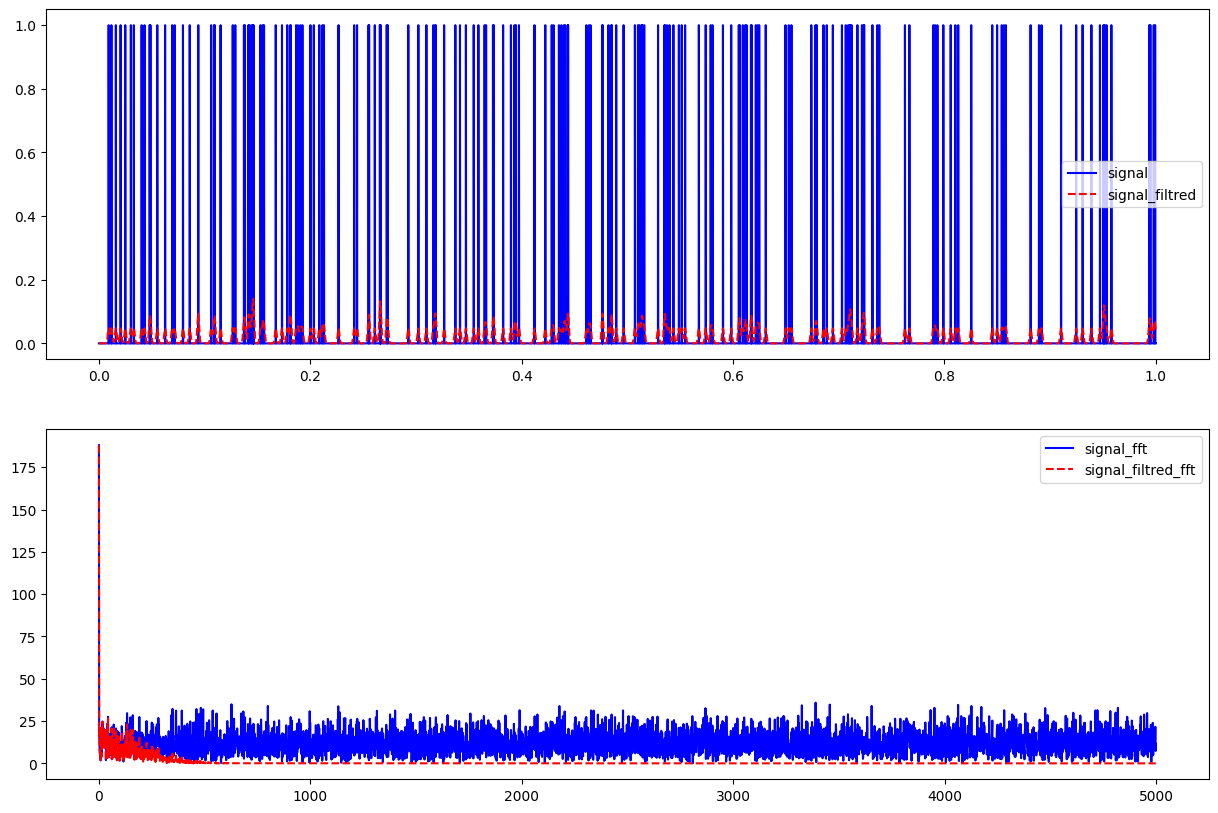

In [11]:
fs = 10_000
t, signal = generate_spike_signal(fs=fs, spike_prob=0.02)
signal_filtred_1 = gaussian_filter(signal, 20)
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='signal', color='blue')
plt.plot(t, signal_filtred_1, label='signal_filtred', color='red', linestyle='--')
plt.legend()

signal_fft, y_fft = compute_spectrum(signal, fs)
signal_filtred_1_fft, y_filtred_1_fft = compute_spectrum(signal_filtred_1, fs)

plt.subplot(2, 1, 2)
plt.plot(signal_fft, y_fft, label='signal_fft', color='blue')
plt.plot(signal_filtred_1_fft, y_filtred_1_fft, label='signal_filtred_fft', color='red', linestyle='--')
plt.legend()

# 4.

In [12]:
def generate_random_spike_signal(fs=10_000, a=-1.0, b=1.0, spike_prob=0.05, A=1.0):
    t = np.linspace(a, b, fs)
    spikes = np.random.rand(fs) < spike_prob
    spikes = np.array([np.random.rand() if i else 0 for i in spikes]) * A
    max_noize, min_noize = A, -A
    flag = 0
    for i in range(1, len(spikes) - 1):
        if flag == 1:
            flag = 0
            continue
        if spikes[i] != 0.0:
            point = np.random.rand() * (max_noize - min_noize) + min_noize
            spikes[i-1] = point
            spikes[i+1] = point
            flag = 1
            continue
    return t, spikes

In [13]:
def custom_median_filter(signal, kernel_size=5, threshold=3):
    signal = np.where(np.abs(signal) > threshold, 0, signal)
    filtered_signal = np.zeros_like(signal)
    half_k = kernel_size // 2
    
    for i in range(len(signal)):
        start = max(0, i - half_k)
        end = min(len(signal), i + half_k + 1)
        
        window = signal[start:end]
        median_value = np.median(window)
        
        filtered_signal[i] = median_value
    return filtered_signal

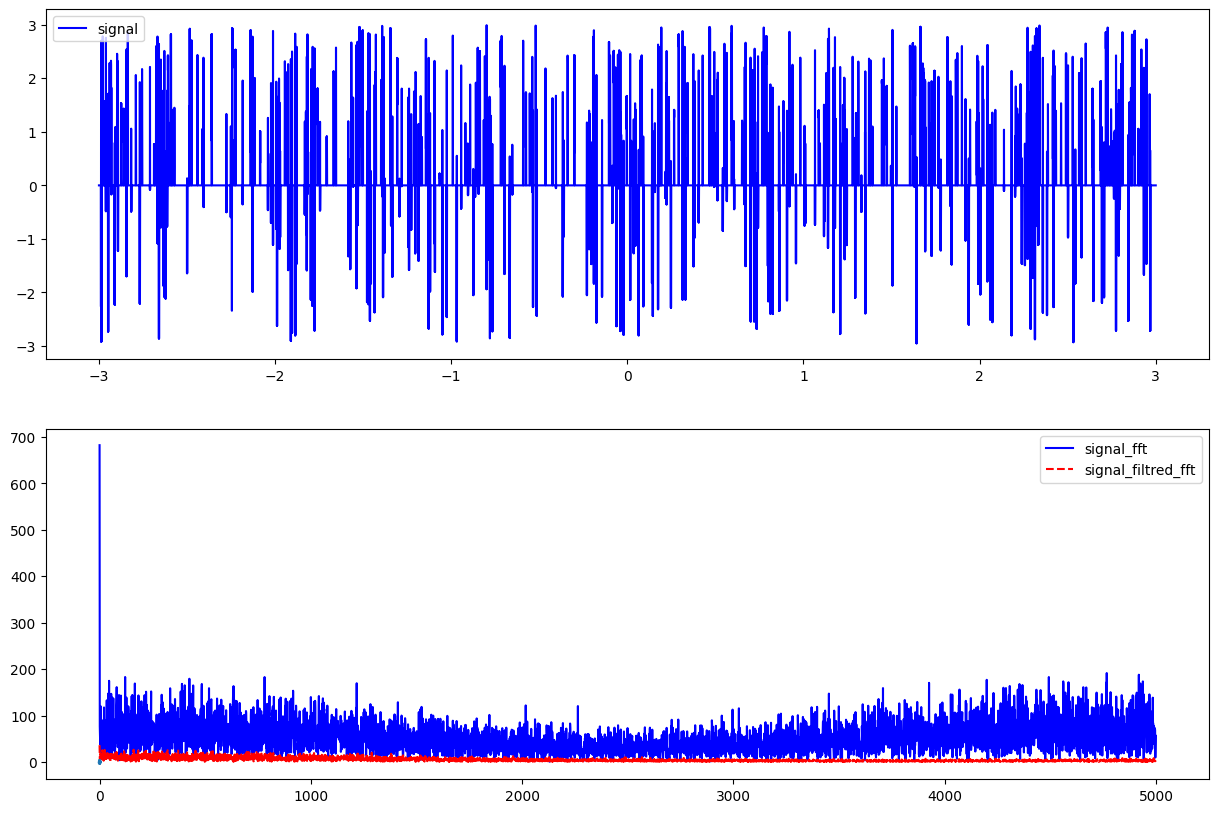

In [29]:
fs=10_000
#t, signal = get_cos_singal(f=[5, 15, 45],fs=fs, a=-1.0, b=1.0, noise=5)
t, signal = generate_random_spike_signal(fs=fs, a=-3, b=3,spike_prob=0.05, A=3)
signal_filtred_1 = custom_median_filter(signal, 6, 2)
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='signal', color='blue')
#plt.plot(t, signal_filtred_1, label='signal_filtred', color='red', linestyle='--')
plt.legend()

signal_fft, y_fft = compute_spectrum(signal, fs)
signal_filtred_1_fft, y_filtred_1_fft = compute_spectrum(signal_filtred_1, fs)

plt.subplot(2, 1, 2)
plt.plot(signal_fft, y_fft, label='signal_fft', color='blue')
plt.plot(signal_filtred_1_fft, y_filtred_1_fft, label='signal_filtred_fft', color='red', linestyle='--')
plt.legend()
plt.plot(t, signal)